In [1]:
# Loading model and vocabulary

from rdkit import Chem
import torch
import sys
import os
sys.path.append(os.getcwd())
print(os.getcwd())
from scaffold_constrained_model import scaffold_constrained_RNN 
from model import RNN
from data_structs import Vocabulary, Experience
from scoring_functions import get_scoring_function
from utils import Variable, seq_to_smiles, fraction_valid_smiles, unique
from rdkit.Chem.Draw import IPythonConsole

voc = Vocabulary(init_from_file="data/DistributionLearningBenchmark/Voc")
    
Agent = scaffold_constrained_RNN(voc)

/site/rp/work/projects/DD/Jupyter/notebooks/Maxime/scaffold-constrained-generation


# Focusing on a chemical serie

In [4]:
from rdkit.Chem import AllChem

if torch.cuda.is_available():
    Agent.rnn.load_state_dict(torch.load("data/DistributionLearningBenchmark/Prior_sureChEMBL_randomized_test_scaffold.ckpt"))
else:
    Agent.rnn.load_state_dict(torch.load("data/DistributionLearningBenchmark/Prior_sureChEMBL_randomized_test_scaffold.ckpt", map_location=lambda storage, loc: storage))
    
seqs, agent_likelihood, entropy = Agent.sample(pattern = 'O=C(N*)c1ccc(*)c(C(F)(F)(*))c1', batch_size=1000)
smiles = seq_to_smiles(seqs, voc)

ecfp4_focused = []
for s in smiles:
    if Chem.MolFromSmiles(s):
        ecfp4_focused.append(np.array(AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(s), 2)))
    
ecfp4_focused = np.array(ecfp4_focused)

/site/rp/work/projects/DD/Jupyter/notebooks/Maxime/scaffold-constrained-generation/scaffold_constrained_model.py:181: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob = F.softmax(logits)
/site/rp/work/projects/DD/Jupyter/notebooks/Maxime/scaffold-constrained-generation/scaffold_constrained_model.py:182: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  log_prob = F.log_softmax(logits)


In [6]:
if torch.cuda.is_available():
    Agent.rnn.load_state_dict(torch.load('data/DistributionLearningBenchmark/Prior_ChEMBL_randomized.ckpt'))
else:
    Agent.rnn.load_state_dict(torch.load('data/DistributionLearningBenchmark/Prior_ChEMBL_randomized.ckpt', map_location=lambda storage, loc: storage))
    
seqs, agent_likelihood, entropy = Agent.sample(pattern = 'O=C(N*)c1ccc(*)c(C(F)(F)(*))c1', batch_size=1000)
smiles = seq_to_smiles(seqs, voc)

ecfp4_normal = []
for s in smiles:
    if Chem.MolFromSmiles(s):
        ecfp4_normal.append(np.array(AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(s), 2)))
    
ecfp4_normal = np.array(ecfp4_normal)

In [ ]:
# 1000 Random ChEMBL molecules, pick one out of 50

suppl = Chem.SmilesMolSupplier('data/ChEMBL_filtered',delimiter='\t',titleLine=False)
count = 0
comparisons_chembl = []
for mol in suppl:
    if np.random.choice(50)>1:
        comparisons_chembl.append(mol)
        count += 1
    if count>1000:
        break

In [9]:
ecfp4_chembl = []
for mol in comparisons_chembl:
    ecfp4_chembl.append(np.array(AllChem.GetMorganFingerprintAsBitVect(mol, 2)))
    
ecfp4_chembl = np.array(ecfp4_chembl)

In [10]:
# Real data from the chemical serie
refs = ['Cc1cc(NC(=O)c2ccc(F)c(C(F)(F)C(=O)N3CCC(F)(F)CC3)c2)ccc1F',
       'CO[C@H]1CC2CC[C@H](C1)N2C(=O)C(F)(F)c1cc(C(=O)Nc2ccc(F)c(C)c2)ccc1F',
       'O=C(Nc1ccc(F)c(F)c1)c1ccc(F)c(C(F)(F)C(=O)N2CCC(O)CC2)c1',
       'Cc1cc(NC(=O)c2ccc(N)c(C(F)(F)C(=O)N3CCC(O)CC3)c2)ccc1F',
       'Cc1cc(NC(=O)c2ccc(F)c(C(F)(F)C(=O)N3CCC(O)(C(N)=O)CC3)c2)ccc1F',
       'Cc1cc(NC(=O)c2ccc(F)c(C(F)(F)C(=O)N3[C@H]4CCC[C@@H]3C[C@H]4O)c2)ccc1F',
       'Cc1cc(NC(=O)c2ccc(F)c(C(F)(F)C(=O)N3[C@H]4CCC[C@@H]3C[C@H](O)C4)c2)ccc1F',
       'Cc1cc(NC(=O)c2ccc(F)c(C(F)(F)C(=O)N3CCC(C)(O)CC3)c2)ccc1F',
       'O=C(Nc1cc(F)c(F)c(F)c1)c1ccc(F)c(C(F)(F)C(=O)N2[C@H]3CC[C@@H]2C[C@@H](O)C3)c1',
       'O=C(Nc1ccc(F)c(Br)c1)c1ccc(F)c(C(F)(F)C(=O)N2CCC(O)(CO)CC2)c1',
       'Cc1cc(NC(=O)c2ccc(F)c(C(F)(F)C(=O)N3C4CC[C@@H]3C[C@@H](C(N)=O)C4)c2)ccc1F',
       'CSNC1CC2CC[C@H](C1)N2C(=O)C(F)(F)c1cc(C(=O)Nc2ccc(F)c(C)c2)ccc1F',
       'Cc1cc(NC(=O)c2ccc(F)c(C(F)(F)C(=O)N3C4CC[C@@H]3C[C@@H](C(=O)N3CCOCC3)C4)c2)ccc1F',
       'Cc1cc(NC(=O)c2ccc(F)c(C(F)(F)C(=O)N3C4CC[C@@H]3C[C@@H](C(=O)O)C4)c2)ccc1F',
       'Cc1cc(NC(=O)c2ccc(F)c(C(F)(F)C(=O)N3C4CC[C@@H]3C[C@@H](C(=O)NCCO)C4)c2)ccc1F',
       'O=C(Nc1ccc(F)c(F)c1)c1ccc(F)c(C(F)(F)C(=O)N2CCCCC2)c1',
       'CC(=O)N[C@@H]1C[C@@H]2CCC[C@H](C1)N2C(=O)C(F)(F)c1cc(C(=O)Nc2ccc(F)c(C)c2)ccc1F',
       'Cc1cc(NC(=O)c2ccc(F)c(C(F)(F)C(=O)N3[C@H]4CCC[C@@H]3C[C@H](N)C4)c2)ccc1F',
       'Cc1cc(NC(=O)c2ccc(F)c(C(F)(F)C(=O)N3CCC(O)CC3)c2)ccc1F',
       'O=C(Nc1cc(F)c(F)c(F)c1)c1ccc(Cl)c(C(F)(F)C(=O)N2CCC(O)CC2)c1',
       'Cc1cc(NC(=O)c2ccc(F)c(C(F)(F)C(=O)N3CCC(N4CCOCC4)CC3)c2)ccc1F',
       'CC(=O)N[C@@H]1CC2CC[C@H](C1)N2C(=O)C(F)(F)c1cc(C(=O)Nc2ccc(F)c(C)c2)ccc1F',
       'Cc1cc(NC(=O)c2ccc(F)c(C(F)(F)C(=O)N3CCC4(CC3)NC(=O)NC4=O)c2)ccc1F',
       'Cc1cc(NC(=O)c2ccc(F)c(C(F)(F)C(=O)N3CC[C@H](O)C[C@H]3C)c2)ccc1F',
       'N#Cc1cc(NC(=O)c2ccc(F)c(C(F)(F)C(=O)N3[C@H]4CC[C@@H]3C[C@H](O)C4)c2)ccc1F',
       'Cc1cc(NC(=O)c2ccc(F)c(C(F)(F)C(=O)N3[C@@H]4CC[C@H](C)[C@H]3CC(O)C4)c2)ccc1F',
       'Cc1cc(NC(=O)c2ccc(F)c(C(F)(F)C(=O)N3[C@@H]4COC[C@H]3CC(=O)C4)c2)ccc1F',
       'O=C(Nc1ccc(F)c(Br)c1)c1ccc(F)c(C(F)(F)C(=O)N2[C@H]3CC[C@@H]2C[C@@H](O)C3)c1',
       'N#Cc1cc(NC(=O)c2ccc(F)c(C(F)(F)C(=O)N3CCC(O)(CO)CC3)c2)ccc1F',
       'Cc1cc(NC(=O)c2ccc(F)c(C(F)(F)C(=O)N3[C@H]4CCC[C@@H]3CC(=O)C4)c2)ccc1F',
       'O=C(Nc1ccc(F)cc1)c1ccc(Cl)c(C(F)(F)C(=O)N2CCC(O)CC2)c1',
       'CN(C(=O)c1ccc(Cl)c(C(F)(F)C(=O)N2CCC(O)CC2)c1)c1ccc(Cl)cc1',
       'Cc1cc(NC(=O)c2ccc(F)c(C(F)(F)C(=O)N3CCC(O)CC3)c2)cc(F)c1F',
       'O=C(Nc1ccc(Cl)cc1)c1ccc(Cl)c(C(F)(F)C(=O)N2CCC(O)CC2)c1',
       'Cc1cc(NC(=O)c2cccc(C(F)(F)C(=O)N3CCC(O)CC3)c2F)ccc1F',
       'Cc1cc(NC(=O)c2cc(F)cc(C(F)(F)C(=O)N3CCC(O)CC3)c2)ccc1F',
       'Cc1cc(NC(=O)c2cc(C(F)(F)C(=O)N3CCC(O)CC3)ccc2Cl)ccc1F',
       'COc1ccc(C(=O)Nc2ccc(F)c(C)c2)cc1C(F)(F)C(=O)N1CCC(O)CC1',
       'CC(=O)N[C@H]1CCN(C(=O)C(F)(F)c2cc(C(=O)Nc3ccc(F)c(C)c3)ccc2F)CC1(C)C',
       'Cc1cc(NC(=O)c2ccc(F)c(C(F)(F)C(=O)N3CCC(O)(CO)CC3)c2)cc(F)c1F',
       'Cc1cc(NC(=O)c2ccc(F)c(C(F)(F)C(=O)N3C4CC[C@@H]3C[C@@H](O)C4)c2)cc(F)c1F',
       'Cc1cc(NC(=O)c2ccc(Cl)c(C(F)(F)C(=O)N3CC[C@@H](O)[C@H](O)C3)c2)ccc1F',
       'Cc1cc(NC(=O)c2ccc(F)c(C(F)(F)C(=O)N3CCC(C)(N)CC3)c2)ccc1F',
       'Cc1cc(NC(=O)c2ccc(F)c(C(F)(F)C(=O)N3CCC(C)(C)CC3)c2)ccc1F',
       'O=C(Nc1ccc(F)c(Br)c1)c1ccc(F)c(C(F)(F)C(=O)N2CCC(O)CC2)c1',
       'O=C(Nc1ccc(F)c(Cl)c1)c1ccc(F)c(C(F)(F)C(=O)N2CCC(O)CC2)c1',
       'O=C(Nc1cc(F)c(F)c(F)c1)c1ccc(F)c(C(F)(F)C(=O)N2CCC(O)CC2)c1',
       'Cc1cc(NC(=O)c2ccc(F)c(C(F)(F)C(=O)N3CCC(C(=O)OC(C)(C)C)CC3)c2)ccc1F',
       'Cc1cc(NC(=O)c2ccc(F)c(C(F)(F)C(=O)N3[C@@H]4CC[C@H](C)[C@H]3C[C@H](N)C4)c2)ccc1F',
       'Cc1cc(NC(=O)c2ccc(F)c(C(F)(F)C(=O)N3[C@@H]4CC[C@H](C)[C@H]3C[C@@H](NS(C)(=O)=O)C4)c2)ccc1F',
       'Cc1cc(NC(=O)c2ccc(F)c(C(F)(F)C(=O)N3[C@H]4CCC[C@@H]3[C@@H](C)CC4)c2)ccc1F',
       'Cc1ccc(C(=O)Nc2ccc(F)c(F)c2)cc1C(F)(F)C(=O)N1CCC(O)CC1',
       'Cc1cc(NC(=O)c2ccc(F)c(C(F)(F)C(=O)N3CCC(C(N)=O)CC3)c2)ccc1F',
       'O=C(Nc1ccc(F)c(Cl)c1)c1ccc(F)c(C(F)(F)C(=O)N2[C@H]3CC[C@@H]2C[C@@H](O)C3)c1',
       'Cc1cc(NC(=O)c2cccc(C(F)(F)C(=O)N3CCC(O)CC3)c2Cl)ccc1F',
       'O=C(Nc1ccc(F)c(Cl)c1)c1ccc(F)c(C(F)(F)C(=O)N2CCC(O)(CO)CC2)c1',
       'O=C(Nc1cc(F)c(F)c(F)c1)c1ccc(F)c(C(F)(F)C(=O)N2[C@H]3CC[C@@H]2C[C@H](O)C3)c1',
       'Cc1cc(NC(=O)c2ccc(F)c(C(F)(F)C(=O)N3[C@H]4CC[C@@H]3C[C@@H](O)C4)c2)ccc1F',
       'O=C(Nc1ccc(F)c(Br)c1)c1ccc(F)c(C(F)(F)C(=O)N2[C@H]3CC[C@@H]2C[C@H](O)C3)c1',
       'O=C(Nc1cc(F)c(F)c(F)c1)c1ccc(F)c(C(F)(F)C(=O)N2CCC(O)(CO)CC2)c1',
       'O=C(Nc1ccc(F)c(F)c1)c1ccc(F)c(C(F)(F)C(=O)N2[C@H]3CC[C@@H]2C[C@@H](O)C3)c1',
       'Cc1cc(NC(=O)c2ccc(F)c(C(F)(F)C(=O)N3[C@H]4CCC[C@@H]3CC(O)C4)c2)ccc1F',
       'Cc1cc(NC(=O)c2cc(C(F)(F)C(=O)N3[C@H]4CC[C@@H]3C[C@@H](O)C4)c(F)cc2F)ccc1F',
       'Cc1cc(NC(=O)c2cc(F)cc(C(F)(F)C(=O)N3[C@H]4CC[C@@H]3C[C@@H](O)C4)c2)ccc1F',
       'O=C(Nc1ccc(F)c(F)c1)c1ccc(F)c(C(F)(F)C(=O)N2CCC(CO)CC2)c1',
       'Cc1cc(NC(=O)c2ccc(F)c(C(F)(F)C(=O)N3C4CC[C@@H]3C[C@H](O)C4)c2)cc(F)c1F',
       'Cc1cc(NC(=O)c2cc(C(F)(F)C(=O)N3[C@H]4CC[C@@H]3C[C@@H](O)C4)ccc2F)ccc1F',
       'Cc1cc(NC(=O)c2ccc(Cl)c(C(F)(F)C(=O)N3[C@H]4CC[C@@H]3C[C@@H](O)C4)c2)ccc1F',
       'Cc1cc(NC(=O)c2ccc(F)c(C(F)(F)C(=O)N3CCC(NC(=O)CC4CCOCC4)CC3)c2)ccc1F',
       'Cc1cc(NC(=O)c2ccc(F)c(C(F)(F)C(=O)N3CCC(NS(C)(=O)=O)CC3)c2)ccc1F',
       'Cc1cc(NC(=O)c2ccc(F)c(C(F)(F)C(=O)N3CCC(N)CC3)c2)ccc1F',
       'Cc1cc(NC(=O)c2ccc(F)c(C(F)(F)C(=O)N3[C@H]4CC[C@@H]3C[C@H](N)C4)c2)ccc1F',
       'Cc1cc(NC(=O)c2ccc(F)c(C(F)(F)C(=O)N3[C@H]4CC[C@@H]3C[C@@H](N)C4)c2)ccc1F',
       'Cc1cc(NC(=O)c2ccc(F)c(C(F)(F)C(=O)N3CCC(NC(=O)OC(C)(C)C)CC3)c2)ccc1F',
       'Cc1cc(NC(=O)c2ccc(F)c(C(F)(F)C(=O)N3[C@H]4CC[C@@H]3C[C@H](NC(=O)OC(C)(C)C)C4)c2)ccc1F',
       'COC(=O)N[C@@H]1C[C@H]2COC[C@@H](C1)N2C(=O)C(F)(F)c1cc(C(=O)Nc2ccc(F)c(C)c2)ccc1F',
       'Cc1cc(NC(=O)c2ccc(Cl)c(C(F)(F)C(=O)N3CCC(O)C(O)C3)c2)ccc1F',
       'Cc1cc(NC(=O)c2ccc(Cl)c(C(F)(F)C(=O)N3CC[C@H](O)[C@H](O)C3)c2)ccc1F',
       'N#Cc1cc(NC(=O)c2ccc(F)c(C(F)(F)C(=O)N3CCC(O)CC3)c2)ccc1F',
       'Cc1cc(NC(=O)c2cc(C(F)(F)C(=O)N3CCC(O)CC3)ccc2F)ccc1F',
       'COc1ccc(C(F)(F)C(=O)N2CCC(O)CC2)cc1C(=O)Nc1ccc(F)c(C)c1',
       'Cc1cc(NC(=O)c2ccc(F)c(C(F)(F)C(=O)N3[C@@H]4COC[C@H]3C[C@H](NS(C)(=O)=O)C4)c2)ccc1F',
       'CC(=O)N[C@H]1C[C@@H]2CCC[C@H](C1)N2C(=O)C(F)(F)c1cc(C(=O)Nc2ccc(F)c(C)c2)ccc1F',
       'O=C(Nc1ccc(F)c(Cl)c1)c1ccc(F)c(C(F)(F)C(=O)N2[C@H]3CC[C@@H]2C[C@H](O)C3)c1',
       'Cc1cc(NC(=O)c2ccc(Cl)c(C(F)(F)C(=O)N3CC[C@@H](O)[C@@H](O)C3)c2)ccc1F',
       'Cc1cc(NC(=O)c2ccc(F)c(C(F)(F)C(=O)N3[C@H]4CC[C@@H](C)[C@@H]3C[C@H](N)C4)c2)ccc1F',
       'CC(=O)N[C@H]1C[C@@H]2CC[C@H](C1)N2C(=O)C(F)(F)c1cc(C(=O)Nc2ccc(F)c(C)c2)ccc1F',
       'O=C(Nc1cc(F)c(F)c(F)c1)c1ccc(Cl)c(C(F)(F)C(=O)N2C3CC[C@@H]2C[C@@H](O)C3)c1',
       'Cc1ccc(C(=O)Nc2cc(F)c(F)c(F)c2)cc1C(F)(F)C(=O)N1[C@H]2CC[C@@H]1C[C@@H](O)C2',
       'Cc1ccc(C(=O)Nc2ccc(F)c(Cl)c2)cc1C(F)(F)C(=O)N1[C@H]2CC[C@@H]1C[C@@H](O)C2',
       'Cc1cc(NC(=O)c2cccc(C(F)(F)C(=O)N3[C@H]4CC[C@@H]3C[C@@H](O)C4)c2F)ccc1F',
       'Cc1cc(NC(=O)c2ccc(F)c(C(F)(F)C(=O)N3[C@H]4CCC[C@@H]3C[C@@H](O)C4)c2)ccc1F',
       'Cc1cc(NC(=O)c2ccc(Cl)c(C(F)(F)C(=O)N3CCCCC3)c2)ccc1F']

ecfp4_original = []
for s in refs:
    if Chem.MolFromSmiles(s):
        ecfp4_original.append(np.array(AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(s), 2)))
    
ecfp4_original = np.array(ecfp4_original)

In [13]:
from numpy import savetxt, loadtxt

savetxt('data/FocusedLearningBenchmark/ecfp4_original', ecfp4_original, delimiter=',')
savetxt('data/FocusedLearningBenchmark/ecfp4_focused', ecfp4_focused, delimiter=',')
savetxt('data/FocusedLearningBenchmark/ecfp4_chembl', ecfp4_chembl, delimiter=',')
savetxt('data/FocusedLearningBenchmark/ecfp4_normal', ecfp4_normal, delimiter=',')

In [1]:
from numpy import savetxt, loadtxt

ecfp4_original = loadtxt('data/FocusedLearningBenchmark/ecfp4_original', delimiter=',')
ecfp4_focused = loadtxt('data/FocusedLearningBenchmark/ecfp4_focused', delimiter=',')
ecfp4_chembl = loadtxt('data/FocusedLearningBenchmark/ecfp4_chembl', delimiter=',')
ecfp4_normal = loadtxt('data/FocusedLearningBenchmark/ecfp4_normal', delimiter=',')

In [2]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

X = np.concatenate((ecfp4_original, ecfp4_focused, ecfp4_chembl, ecfp4_normal))
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

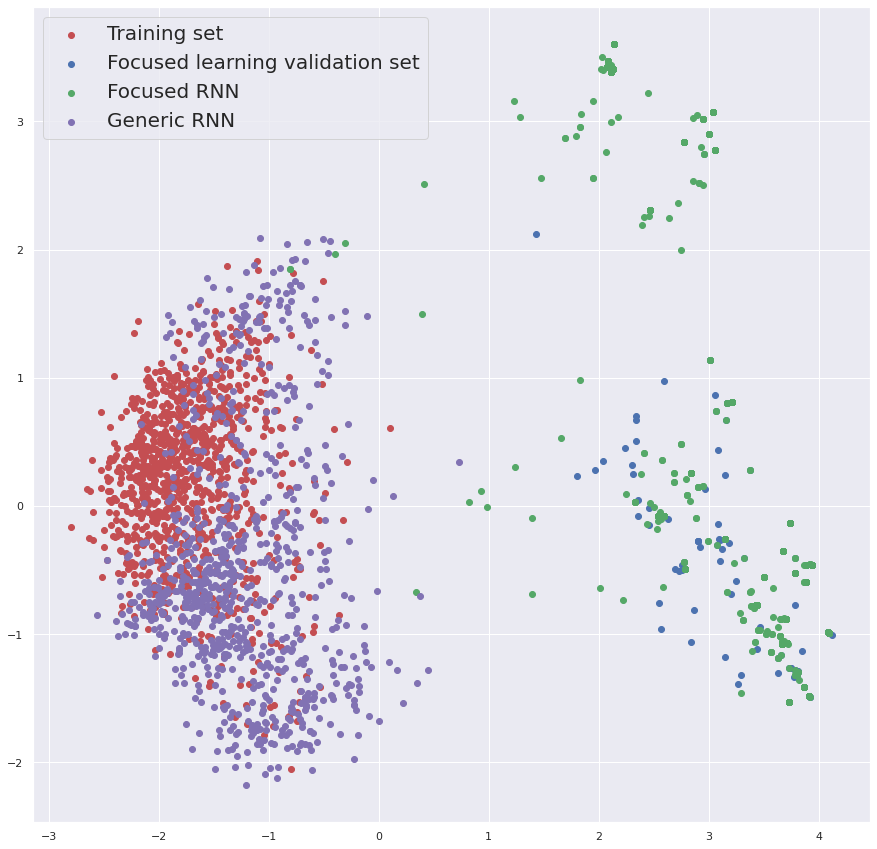

In [3]:
import seaborn as sns
import matplotlib 
%matplotlib inline 

sns.set()

plt.figure(figsize=(15, 15))

plt.subplot(111)
plt.scatter(X_pca[(len(ecfp4_original)+len(ecfp4_focused)):(len(ecfp4_original)+len(ecfp4_focused) + len(ecfp4_chembl)), 0], X_pca[(len(ecfp4_original)+len(ecfp4_focused)):(len(ecfp4_original)+len(ecfp4_focused) + len(ecfp4_chembl)), 1], c='r', label='Training set')
plt.scatter(X_pca[:len(ecfp4_original), 0], X_pca[:len(ecfp4_original), 1], c='b', label='Focused learning validation set')
plt.scatter(X_pca[len(ecfp4_original):(len(ecfp4_original)+len(ecfp4_focused)), 0], X_pca[len(ecfp4_original):(len(ecfp4_original)+len(ecfp4_focused)), 1], c='g', label='Focused RNN')
plt.scatter(X_pca[(len(ecfp4_original)+len(ecfp4_focused) + len(ecfp4_chembl)):, 0], X_pca[(len(ecfp4_original)+len(ecfp4_focused) + len(ecfp4_chembl)):, 1], c='m', label='Generic RNN')

plt.legend(prop={'size': 20})